In [2]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

# model1name = "Bonzanni2013"
# model2name = "Krumsiek2011"

# BeatAML
805 patients (942 specimens) in total. 
> For DNA sequencing, we used the 11.9 megabase custom capture library that was developed to provide coverage of all variants previously reported in AML (including all variants that were detected from exome sequencing in our prior study).

# Clinical Outcome
## Data
Mutation, clinical data and drug response data are downloaded from the [BeatAML2 website](https://biodev.github.io/BeatAML2/):
1. [WES/targeted Sequencing Mutation Calls](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt)
2. [Clinical Summary](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx)
3. [Inhibitor AUC values](https://github.com/biodev/beataml2.0_data/raw/main/beataml_probit_curve_fits_v4_dbgap.txt)
4. [Inhibitor Families](https://github.com/biodev/beataml2.0_data/raw/main/beataml_drug_families.xlsx)

## Methods
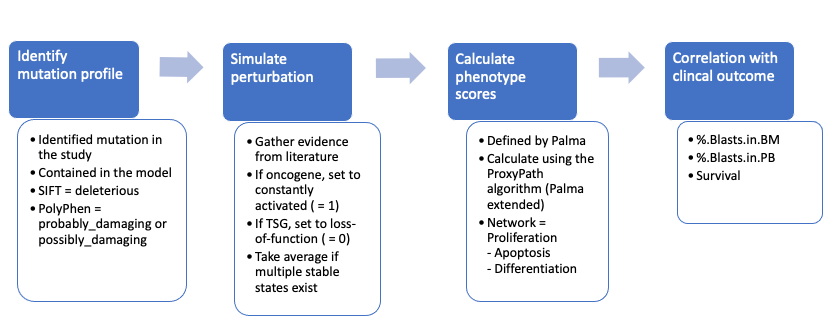

In [3]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations, chain  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
import xml.etree.ElementTree as ET # for parse the SBML file
import seaborn as sns # for plotting
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy import stats
from matplotlib.gridspec import GridSpec

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [3]:
# Convert txt to SBML
from rpy2.robjects.packages import importr
boolnet = importr("BoolNet")

merged_and_name = "./Models/merged_and_" + model1name + "_" + model2name
merged_inhibitor_wins_name = "./Models/merged_inhibitor_wins_" + model1name + "_" + model2name
merged_or_name = "./Models/merged_or_" + model1name + "_" + model2name

for modelname in [merged_and_name, merged_inhibitor_wins_name, merged_or_name]:
    net = boolnet.loadNetwork(modelname + ".txt")
    boolnet.toSBML(net, modelname + ".sbml")
    print(modelname)
    print(boolnet.loadSBML(modelname + ".sbml"))
    print("_________________________________")

./Models/merged_and_Bonzanni2013_Krumsiek2011
Boolean network with 18 genes

Involved genes:
ERG CBFA2T3 RUNX1 SMAD6 HHEX KLF1 CEBPA JUN EGR1 EGR2 NAB1 GFI1 GATA1 GATA2 ZFPM1 TAL1 SPI1 FLI1

Transition functions:
ERG = ((FLI1 | ERG | GATA2 | RUNX1) & !(TAL1 & CBFA2T3))
CBFA2T3 = (TAL1 & GATA2)
RUNX1 = ((SPI1 | RUNX1 | FLI1 | ERG | (GATA2 & TAL1)) & !(RUNX1 & SMAD6))
SMAD6 = (ERG | FLI1 | (TAL1 & GATA2))
HHEX = (FLI1 | ERG | (TAL1 & GATA2))
KLF1 = (GATA1 & !FLI1)
CEBPA = (CEBPA & !(GATA1 & ZFPM1 & TAL1))
JUN = (SPI1 & !GFI1)
EGR1 = ((SPI1 & JUN) & !GFI1)
EGR2 = ((SPI1 & JUN) & !GFI1)
NAB1 = ((SPI1 & JUN) & !GFI1)
GFI1 = (CEBPA & !(EGR1 | EGR2 | NAB1))
GATA1 = ((TAL1 & GATA1) & !(SPI1 & GATA1) & (GATA1 | GATA2 | FLI1) & !SPI1)
GATA2 = ((FLI1 | ERG | (TAL1 & GATA2)) & !(GATA1 & ZFPM1) & !(GATA2 & HHEX) & GATA2 & !(GATA1 & ZFPM1) & SPI1)
ZFPM1 = (GATA2 & TAL1 & GATA1)
TAL1 = ((FLI1 | ERG | (FLI1 & GATA2) | (TAL1 & GATA1) | (GATA2 & TAL1)) & GATA1 & !SPI1)
SPI1 = (FLI1 & !(SPI1 & GATA1) & (

In [4]:
# Read the data
mutations = pd.read_csv("./Data/BeatAML/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("./Data/BeatAML/beataml_wv1to4_clinical.xlsx")
classification = pd.read_csv("./Models/Annotations/class_"+ model1name + "_" + model2name +".csv")

model1 = biolqm.load("./Models/" + model1name + ".sbml")
model2 = biolqm.load("./Models/" + model2name + ".sbml")
merged_and = biolqm.load("./Models/merged_and_" + model1name + "_" + model2name + ".sbml")
merged_inhibitor_wins = biolqm.load("./Models/merged_inhibitor_wins_" + model1name + "_" + model2name + ".sbml")
merged_or = biolqm.load("./Models/merged_or_" + model1name + "_" + model2name + ".sbml")

In [5]:
# Get genes in each model
def getnodes(model_name):
    # Load and parse the SBML file
    tree = ET.parse("./Models/" + model_name + ".sbml")
    root = tree.getroot()
    
    # Define the namespace for SBML Level 3 Version 1 Core and Qual
    ns = {
        'sbml': 'http://www.sbml.org/sbml/level3/version1/core',
        'qual': 'http://www.sbml.org/sbml/level3/version1/qual/version1'
    }
    
    # Find all qualitativeSpecies in the model
    qual_species_list = root.findall('.//qual:qualitativeSpecies', ns)
    
    # Extract the IDs of the qualitativeSpecies
    qual_species_ids = []
    for species in qual_species_list:
        species_id = species.attrib.get('{http://www.sbml.org/sbml/level3/version1/qual/version1}id')
        if species_id:
            qual_species_ids.append(species_id)

    print(qual_species_ids)
    return qual_species_ids
    
gene_model1 = getnodes(model1name)
gene_model2 = getnodes(model2name)
gene_merged = list(set(gene_model1 + gene_model2))

['AKT1', 'CDKN2A', 'BCL2', 'CCND1', 'CEBPA', 'DNMT3A', 'MAPK1', 'ETV6', 'FBXW7', 'FLT3', 'GSK3B', 'HOXA9', 'MEIS1', 'MYC', 'NPM1', 'SOX4', 'STAT5A', 'TP53']
['External_quiescence', 'External_cycling', 'PIK3CA', 'TSC1', 'MTOR', 'FOXO3', 'ATM', 'ROS1', 'Mitochondria', 'Autophagy', 'ERAS', 'ETS1', 'MEFV', 'GSK3B', 'CTNNB1', 'MYC', 'BMI1', 'MDM2', 'TP53', 'CDKN1C', 'CDKN1A', 'CDKN1B', 'GFI1', 'RB1', 'E2F1', 'CCND1', 'CCNE1', 'S_phase', 'AKT1', 'CDKN2D', 'CDKN2A', 'Pro_apoptotic_proteins', 'Anti_apoptotic_proteins', 'CYCS', 'Apoptosis', 'Senescence']


In [6]:
# Merge the df based on sample id
clinical_df = pd.merge(
    left=mutations,
    right=clinical,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample'
)
clinical_df['survivalYears'] = clinical_df['ageAtDiagnosis'] + clinical_df['overallSurvival']/365

# Filter the 'mutations' DataFrame
mutations_df = clinical_df[
    (clinical_df['symbol'].isin(gene_model1)) &
    (
        # Apply 'sift' and 'polyphen' filters 
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging')))
    ))
]
mutations_df_2 = clinical_df[
    (clinical_df['symbol'].isin(gene_model2)) &
    (
        # Apply 'sift' and 'polyphen' filters 
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging')))
    ))
]
# mutations_df = clinical_df[clinical_df['symbol'].isin(gene_model1)]
# mutations_df_2 = clinical_df[clinical_df['symbol'].isin(gene_model2)]

patient_to_mutations = mutations_df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()
patient_to_mutations_2 = mutations_df_2.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()

# Generate unique mutation profiles and their perturbation strings
classification_dict = classification.set_index('symbol')['class'].to_dict()

def generate_perturbation_string(mutations):
    perturbations = []
    for mutation in mutations:
        class_type = classification_dict.get(mutation)
        if class_type == 'oncogene':
            perturbations.append(f"{mutation}%1")
        elif class_type == 'TSG':
            perturbations.append(f"{mutation}%0")
    return " ".join(perturbations)

# def generate_perturbation_string(mutations):
#     perturbations = []
#     for mutation in mutations:
#         perturbations.append(f"{mutation}%0")
#     return " ".join(perturbations)
    
patient_to_mutations['perturbation_string'] = patient_to_mutations['symbol'].apply(generate_perturbation_string)
patient_to_mutations_2['perturbation_string'] = patient_to_mutations_2['symbol'].apply(generate_perturbation_string)

unique_perturbations = patient_to_mutations['perturbation_string'].unique()
unique_perturbations_2 = patient_to_mutations_2['perturbation_string'].unique()

# Map the simulation results back to each patient
patient_to_mutations['symbol'] = patient_to_mutations['symbol'].str.join(', ')
print("# of patients per mutation profile:")
patient_to_mutations['symbol'].value_counts()

# of patients per mutation profile:


symbol
DNMT3A           102
FLT3              51
TP53              42
DNMT3A, FLT3      13
MYC                4
TP53, DNMT3A       4
ETV6               2
DNMT3A, MYC        2
CEBPA              2
NPM1, DNMT3A       1
CEBPA, DNMT3A      1
NPM1               1
Name: count, dtype: int64

## Using the ProxPath to define phenotype scores

An algorithm that, given a set of proteins, estimates its regulatory impact over phenotypes and pathways annotated in SIGNOR.
   
I have checked that nodes derived from the ProxPath cover all nodes in Palma's calculation function.

In [7]:
%run 'ProxPath.ipynb'

mutations_df = mutations_df.copy()
mutations_df_2 = mutations_df_2.copy()

pheno_model1 = proxpath(gene_model1)
pheno_model2 = proxpath(gene_model2)

# Calculate the phenotype score
perturbation_to_scores = {}
perturbation_to_scores_2 = {}

phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_model1_unique = pheno_model1.drop_duplicates(subset=['QueryNode', 'EndNode'])
pheno_model2_unique = pheno_model2.drop_duplicates(subset=['QueryNode', 'EndNode'])

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(model1, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']               
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

for perturbation in unique_perturbations_2:
    if perturbation: 
        model_perturbed = biolqm.perturbation(model2, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_model2_unique[pheno_model2_unique['EndNode'] == phenotype]    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']               
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores_2[perturbation] = results.loc['NETWORK'].item()
        
# mapping dbgap_subject_id to symbol (mutation profile)
subject_to_symbol = patient_to_mutations[['dbgap_subject_id', 'symbol']].set_index('dbgap_subject_id').to_dict()['symbol']
mutations_df['mutation_profile_model1'] = mutations_df['dbgap_subject_id'].map(subject_to_symbol)

subject_to_symbol_2 = patient_to_mutations_2[['dbgap_subject_id', 'symbol']].set_index('dbgap_subject_id').to_dict()['symbol']
mutations_df_2['mutation_profile_model2'] = mutations_df_2['dbgap_subject_id'].map(subject_to_symbol_2)

# Update 'mutation_profile' to 'wildtype' where it is blank or NaN
mutations_df.loc[mutations_df['mutation_profile_model1'].isna() | (mutations_df['mutation_profile_model1'] == ''), 'mutation_profile_model1'] = 'wildtype'
mutations_df_2.loc[mutations_df_2['mutation_profile_model2'].isna() | (mutations_df_2['mutation_profile_model2'] == ''), 'mutation_profile_model2'] = 'wildtype'

# Map the simulation results back to each patient
patient_to_mutations['network_score_model1'] = patient_to_mutations['perturbation_string'].map(perturbation_to_scores)
patient_to_mutations_2['network_score_model2'] = patient_to_mutations_2['perturbation_string'].map(perturbation_to_scores_2)

# mapping dbgap_subject_id to network_score
subject_to_score = patient_to_mutations[['dbgap_subject_id', 'network_score_model1']].set_index('dbgap_subject_id').to_dict()['network_score_model1']
mutations_df['network_score_model1'] = mutations_df['dbgap_subject_id'].map(subject_to_score)
subject_to_score_2 = patient_to_mutations_2[['dbgap_subject_id', 'network_score_model2']].set_index('dbgap_subject_id').to_dict()['network_score_model2']
mutations_df_2['network_score_model2'] = mutations_df_2['dbgap_subject_id'].map(subject_to_score_2)

# Update 'network_score' for wildtype
fps = biolqm.fixpoints(model1)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
mutations_df.loc[mutations_df['mutation_profile_model1'] == 'wildtype', 'network_score_model1'] = results.loc['NETWORK'].item()

fps = biolqm.fixpoints(model2)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model2_unique[pheno_model2_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
mutations_df_2.loc[mutations_df_2['mutation_profile_model2'] == 'wildtype', 'network_score_model2'] = results.loc['NETWORK'].item()

# The merged models

In [8]:
# Filter the 'mutations' DataFrame
merged_df = clinical_df[
    (clinical_df['symbol'].isin(gene_merged)) &
    (
        # Apply 'sift' and 'polyphen' filters
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging'))))
    )
]

# merged_df = clinical_df[clinical_df['symbol'].isin(gene_merged)]
patient_to_mutations = merged_df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()

# Generate unique mutation profiles and their perturbation strings
classification_dict = classification.set_index('symbol')['class'].to_dict()

def generate_perturbation_string(mutations):
    perturbations = []
    for mutation in mutations:
        class_type = classification_dict.get(mutation)
        if class_type == 'oncogene':
            perturbations.append(f"{mutation}%1")
        elif class_type == 'TSG':
            perturbations.append(f"{mutation}%0")
    return " ".join(perturbations)

# def generate_perturbation_string(mutations):
#     perturbations = []
#     for mutation in mutations:
#         perturbations.append(f"{mutation}%0")
#     return " ".join(perturbations)
    
patient_to_mutations['perturbation_string'] = patient_to_mutations['symbol'].apply(generate_perturbation_string)
unique_perturbations = patient_to_mutations['perturbation_string'].unique()

# Map the simulation results back to each patient
patient_to_mutations['symbol'] = patient_to_mutations['symbol'].str.join(', ')
print("# of patients per mutation profile:")
patient_to_mutations['symbol'].value_counts()

# of patients per mutation profile:


symbol
DNMT3A           102
FLT3              51
TP53              42
DNMT3A, FLT3      13
MYC                4
TP53, DNMT3A       4
ATM                2
ETV6               2
DNMT3A, MYC        2
CEBPA              2
NPM1, DNMT3A       1
PIK3CA             1
CEBPA, DNMT3A      1
MTOR               1
NPM1               1
Name: count, dtype: int64

In [9]:
merged_df = merged_df.copy()

# Calculate the phenotype score
pheno_merged = proxpath(gene_merged)
perturbation_to_scores = {}
phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_merged_unique = pheno_merged.drop_duplicates(subset=['QueryNode', 'EndNode'])

#___________________ merged_and _________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# mapping dbgap_subject_id to symbol (mutation profile)
subject_to_symbol = patient_to_mutations[['dbgap_subject_id', 'symbol']].set_index('dbgap_subject_id').to_dict()['symbol']
merged_df['mutation_profile_merged'] = merged_df['dbgap_subject_id'].map(subject_to_symbol)

# Update 'mutation_profile' to 'wildtype' where it is blank or NaN
merged_df.loc[merged_df['mutation_profile_merged'].isna() | (merged_df['mutation_profile_merged'] == ''), 'mutation_profile_merged'] = 'wildtype'

# Map the simulation results back to each patient
patient_to_mutations['network_score'] = patient_to_mutations['perturbation_string'].map(perturbation_to_scores)

# mapping dbgap_subject_id to network_score
subject_to_score = patient_to_mutations[['dbgap_subject_id', 'network_score']].set_index('dbgap_subject_id').to_dict()['network_score']
merged_df['network_score_merged_and'] = merged_df['dbgap_subject_id'].map(subject_to_score)

# Update 'network_score' 
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
merged_df.loc[merged_df['mutation_profile_merged'] == 'wildtype', 'network_score_merged_and'] = results.loc['NETWORK'].item()

#___________________ merged_inhibitor_wins _________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Map the simulation results back to each patient
patient_to_mutations['network_score'] = patient_to_mutations['perturbation_string'].map(perturbation_to_scores)

# mapping dbgap_subject_id to network_score
subject_to_score = patient_to_mutations[['dbgap_subject_id', 'network_score']].set_index('dbgap_subject_id').to_dict()['network_score']
merged_df['network_score_merged_inhibitor_wins'] = merged_df['dbgap_subject_id'].map(subject_to_score)

# Update 'network_score' 
fps = biolqm.fixpoints(merged_inhibitor_wins)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
merged_df.loc[merged_df['mutation_profile_merged'] == 'wildtype', 'network_score_merged_inhibitor_wins'] = results.loc['NETWORK'].item()

#___________________ merged_or _________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Map the simulation results back to each patient
patient_to_mutations['network_score'] = patient_to_mutations['perturbation_string'].map(perturbation_to_scores)

# mapping dbgap_subject_id to network_score
subject_to_score = patient_to_mutations[['dbgap_subject_id', 'network_score']].set_index('dbgap_subject_id').to_dict()['network_score']
merged_df['network_score_merged_or'] = merged_df['dbgap_subject_id'].map(subject_to_score)

# Update 'network_score' 
fps = biolqm.fixpoints(merged_or)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
merged_df.loc[merged_df['mutation_profile_merged'] == 'wildtype', 'network_score_merged_or'] = results.loc['NETWORK'].item()

In [10]:
# merge the model1, model2 scores and merged model scores
df1 = mutations_df[['dbgap_subject_id','mutation_profile_model1', 'network_score_model1']]
df1 = df1.groupby('dbgap_subject_id').agg({
    'network_score_model1': 'mean',
    'mutation_profile_model1': 'first'
}).reset_index()
df2 = mutations_df_2[['dbgap_subject_id','mutation_profile_model2','network_score_model2']]
df2 = df2.groupby('dbgap_subject_id').agg({
    'network_score_model2': 'mean',
    'mutation_profile_model2': 'first'
}).reset_index()
mutations_df = merged_df.merge(df1, on='dbgap_subject_id', how='left').merge(df2, on='dbgap_subject_id', how='left')

In [11]:
def correlation_plot(pheno, clinical_variable):
    mutation_profile = 'mutation_profile_merged'
    
    df = mutations_df
    # Convert clinical_variable to numeric, coercing errors to NaN
    df[clinical_variable] = pd.to_numeric(df[clinical_variable], errors='coerce')
    # Aggregate to ensure one row per patient
    aggregated_df = df.groupby('dbgap_subject_id').agg({
        clinical_variable: 'mean', 
        pheno: 'first',
        mutation_profile: 'first'
    }).reset_index()
    
    # Drop rows where either clinical_variable or pheno is NaN
    aggregated_df = aggregated_df.dropna(subset=[clinical_variable, pheno])
    
    if len(aggregated_df) > 1:  # Ensure there are at least 2 data points
        pc, p_value = pearsonr(aggregated_df[clinical_variable], aggregated_df[pheno])
    
        # Plotting
        plt.figure(figsize=(6, 6))
        
        # Get unique mutation profiles and assign colors
        unique_profiles = aggregated_df[mutation_profile].unique()
        palette = sns.color_palette("Set2", len(unique_profiles))
        color_dict = dict(zip(unique_profiles, palette))
        
        # Plot the regression line using seaborn (without scatter points)
        plot = sns.regplot(x=pheno, y=clinical_variable, data=aggregated_df, ci=None, scatter=False, color='gray')

        # Plot points with colors based on 'mutation_profile'
        for _, row in aggregated_df.iterrows():
            alpha_value = 0.1 if row[mutation_profile] == 'wildtype' else 1
            color_value = "Grey" if row[mutation_profile] == 'wildtype' else color_dict[row[mutation_profile]]
            plt.scatter(row[pheno], row[clinical_variable], color=color_value, 
                        s=50, alpha=alpha_value, label=row[mutation_profile])
        
        annotated_profiles = set()  # Keep track of annotated mutation profiles
        for _, row in aggregated_df.iterrows():
            profile = row[mutation_profile]
            # Annotate each unique mutation profile only once
            if profile not in annotated_profiles:
                plt.annotate(profile, (row[pheno], row[clinical_variable]), fontsize=9)
                annotated_profiles.add(profile)
                
        plt.title('Correlation analysis of ' + clinical_variable + ' vs ' + pheno)
        plt.xlabel(pheno)
        plt.ylabel(clinical_variable)
        # Annotating the plot with Pearson Correlation and p-value
        plt.text(0.01, 0.99, f'Pearson Correlation: {pc:.2f}\nP-value: {p_value:.2g}', transform=plot.transAxes, verticalalignment='top')
    
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")

def correlation_pc(clinical_variable):
    mutation_profile = 'mutation_profile_merged'
    df = mutations_df
    # Convert clinical_variable to numeric, coercing errors to NaN
    df[clinical_variable] = pd.to_numeric(df[clinical_variable], errors='coerce')
    
    pc_results = pd.DataFrame()
    # loop through the models
    models = ['model1', 'model2','merged_and', 'merged_inhibitor_wins', 'merged_or']
    for model in models:
        pheno = "network_score_" + model
        
        # Aggregate to ensure one row per patient
        aggregated_df = df.groupby('dbgap_subject_id').agg({
            clinical_variable: 'mean', 
            pheno: 'first',
            mutation_profile: 'first'
        }).reset_index()
        
        # Drop rows where either clinical_variable or pheno is NaN
        aggregated_df = aggregated_df.dropna(subset=[clinical_variable, pheno])
        
        # Extract hazard ratio and phenotype values
        x = aggregated_df[pheno]
        y = aggregated_df[clinical_variable]
        
        # Calculate Pearson Correlation and p-value
        pc_results.loc[model, 'pc'], pc_results.loc[model, 'p_value'] = pearsonr(x, y)
    print('Person Correlation of '+ clinical_variable + ' vs network score')
    return pc_results

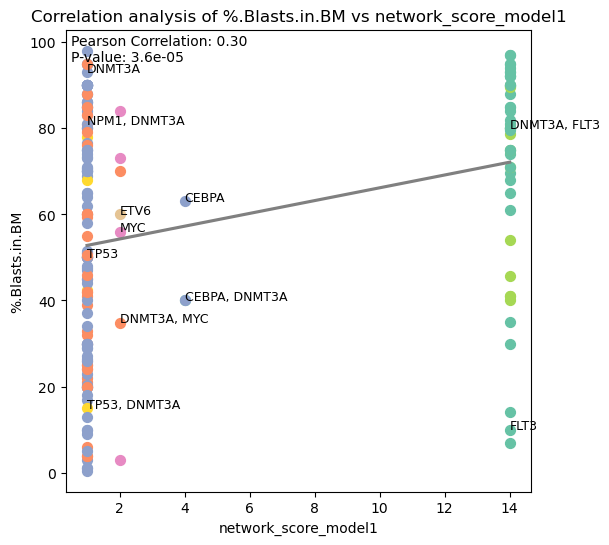

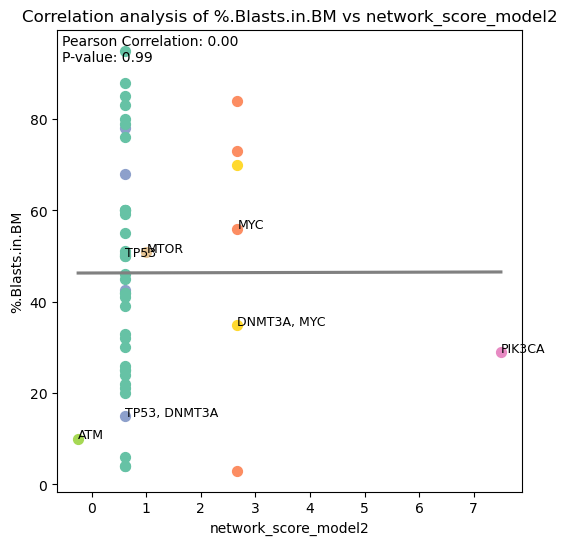

In [12]:
correlation_plot('network_score_model1', '%.Blasts.in.BM')
correlation_plot('network_score_model2', '%.Blasts.in.BM')

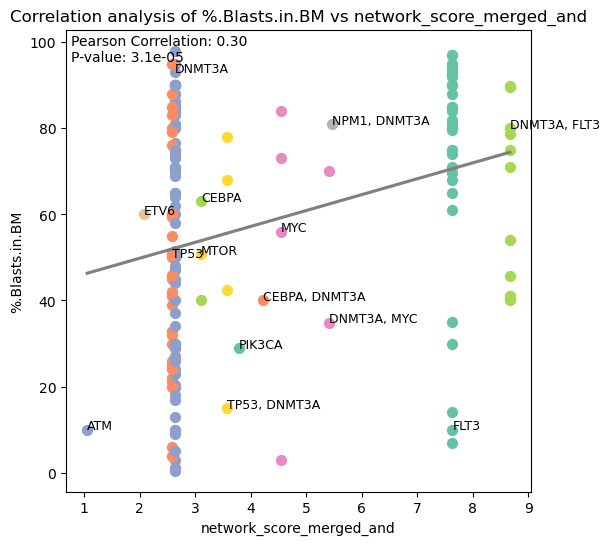

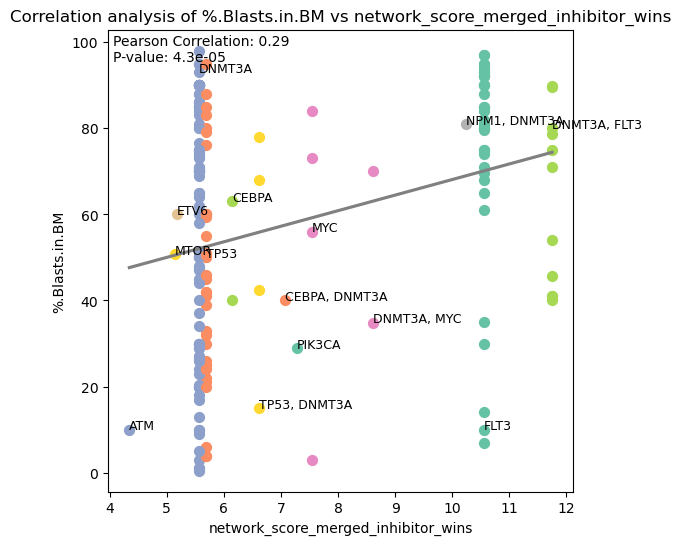

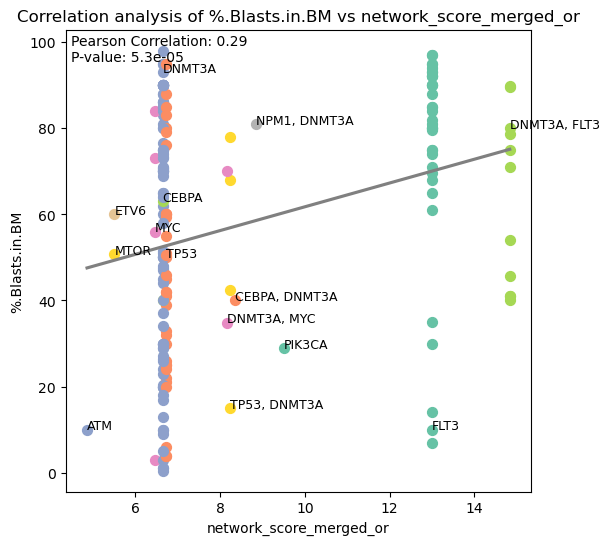

In [13]:
correlation_plot('network_score_merged_and', '%.Blasts.in.BM')
correlation_plot('network_score_merged_inhibitor_wins', '%.Blasts.in.BM')
correlation_plot('network_score_merged_or', '%.Blasts.in.BM')

In [14]:
correlation_pc('%.Blasts.in.BM')

Person Correlation of %.Blasts.in.BM vs network score


,pc,p_value
model1,0.298641,0.000036
model2,0.001433,0.992288
merged_and,0.298974,0.000031
merged_inhibitor_wins,0.293573,0.000043
merged_or,0.290466,0.000053


## Aggregate over mutation profile

In [15]:
def correlation_plot_avg(pheno, clinical_variable):
    mutation_profile = 'mutation_profile_merged'
    
    df = mutations_df
    # Convert clinical_variable to numeric, coercing errors to NaN
    df[clinical_variable] = pd.to_numeric(df[clinical_variable], errors='coerce')
    # Aggregate to ensure one row per patient
    patient_df = df.groupby('dbgap_subject_id').agg({
        clinical_variable: 'mean', 
        pheno: 'first',
        mutation_profile: 'first'
    }).reset_index()

    # Aggregate to take average over clinical outcomes
    aggregated_df = patient_df.groupby(mutation_profile).agg({
        clinical_variable: 'mean', 
        pheno: 'first'
    }).reset_index()
    
    # Drop rows where either clinical_variable or pheno is NaN
    aggregated_df = aggregated_df.dropna(subset=[clinical_variable, pheno])
    
    if len(aggregated_df) > 1:  # Ensure there are at least 2 data points
        pc, p_value = pearsonr(aggregated_df[clinical_variable], aggregated_df[pheno])
    
        # Plotting
        plt.figure(figsize=(6, 6))
        
        # Get unique mutation profiles and assign colors
        unique_profiles = aggregated_df[mutation_profile].unique()
        palette = sns.color_palette("Set2", len(unique_profiles))
        color_dict = dict(zip(unique_profiles, palette))
        
        # Plot the regression line using seaborn (without scatter points)
        plot = sns.regplot(x=pheno, y=clinical_variable, data=aggregated_df, ci=None, scatter=False, color='gray')

        # Plot points with colors based on 'mutation_profile'
        for _, row in aggregated_df.iterrows():
            alpha_value = 0.1 if row[mutation_profile] == 'wildtype' else 1
            color_value = "Grey" if row[mutation_profile] == 'wildtype' else color_dict[row[mutation_profile]]
            plt.scatter(row[pheno], row[clinical_variable], color=color_value, 
                        s=50, alpha=alpha_value, label=row[mutation_profile])
        
        annotated_profiles = set()  # Keep track of annotated mutation profiles
        for _, row in aggregated_df.iterrows():
            profile = row[mutation_profile]
            # Annotate each unique mutation profile only once
            if profile not in annotated_profiles:
                plt.annotate(profile, (row[pheno], row[clinical_variable]), fontsize=9)
                annotated_profiles.add(profile)
                
        plt.title('Correlation analysis of ' + clinical_variable + ' vs ' + pheno)
        plt.xlabel(pheno)
        plt.ylabel(clinical_variable)
        # Annotating the plot with Pearson Correlation and p-value
        plt.text(0.01, 0.99, f'Pearson Correlation: {pc:.2f}\nP-value: {p_value:.2g}', transform=plot.transAxes, verticalalignment='top')
    
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")

In [16]:
def correlation_pc_avg(clinical_variable):
    mutation_profile = 'mutation_profile_merged'
    df = mutations_df
    # Convert clinical_variable to numeric, coercing errors to NaN
    df[clinical_variable] = pd.to_numeric(df[clinical_variable], errors='coerce')
    
    pc_results = pd.DataFrame()
    # loop through the models
    models = ['model1','model2', 'merged_and', 'merged_inhibitor_wins', 'merged_or']
    for model in models:
        pheno = "network_score_" + model
        # Aggregate to ensure one row per patient
        patient_df = df.groupby('dbgap_subject_id').agg({
            clinical_variable: 'mean', 
            pheno: 'first',
            mutation_profile: 'first'
        }).reset_index()
    
        # Aggregate to take average over clinical outcomes
        aggregated_df = patient_df.groupby(mutation_profile).agg({
            clinical_variable: 'mean', 
            pheno: 'first'
        }).reset_index()
        
        # Drop rows where either clinical_variable or pheno is NaN
        aggregated_df = aggregated_df.dropna(subset=[clinical_variable, pheno])
        
        # Extract hazard ratio and phenotype values
        x = aggregated_df[pheno]
        y = aggregated_df[clinical_variable]
        
        # Calculate Pearson Correlation and p-value
        pc_results.loc[model, 'pc'], pc_results.loc[model, 'p_value'] = pearsonr(x, y)
    print('Person Correlation of '+ clinical_variable + ' vs network score')
    return pc_results

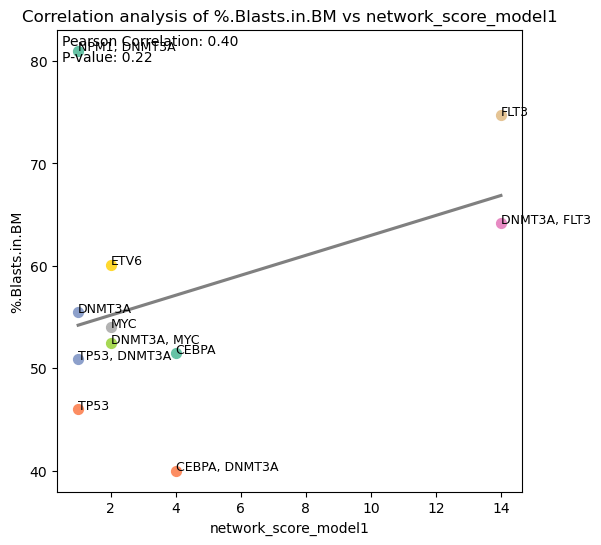

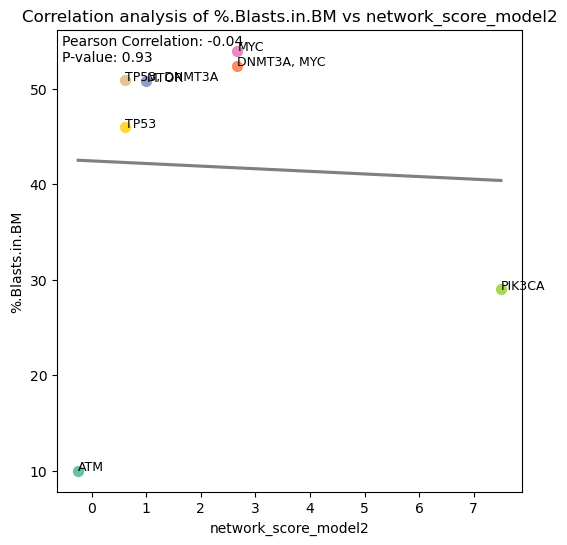

In [17]:
correlation_plot_avg( 'network_score_model1', '%.Blasts.in.BM')
correlation_plot_avg( 'network_score_model2', '%.Blasts.in.BM')

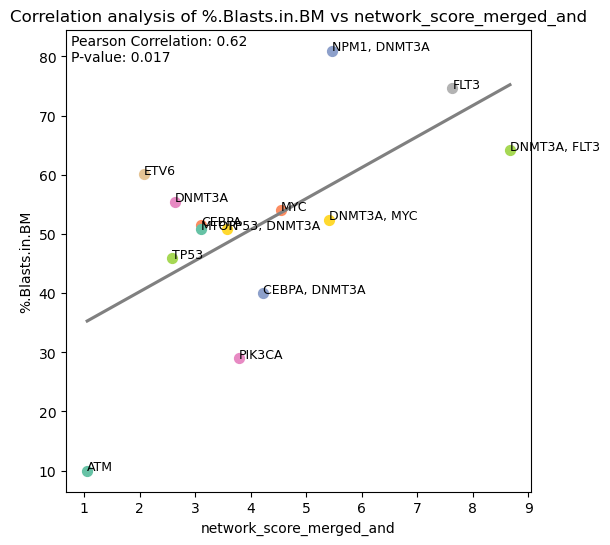

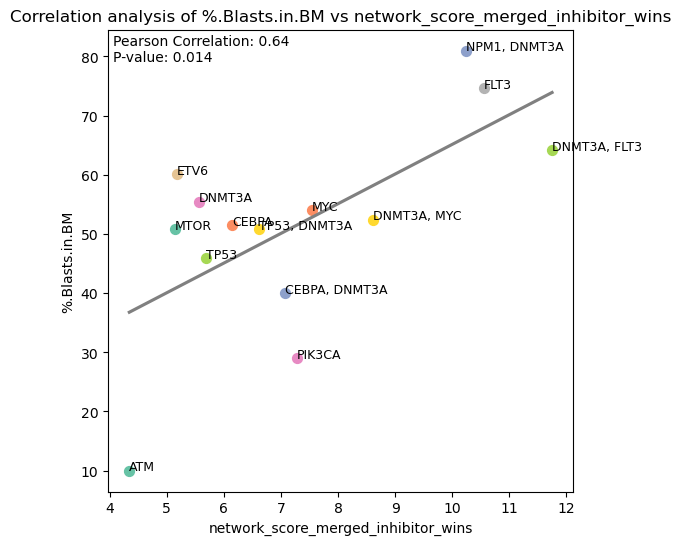

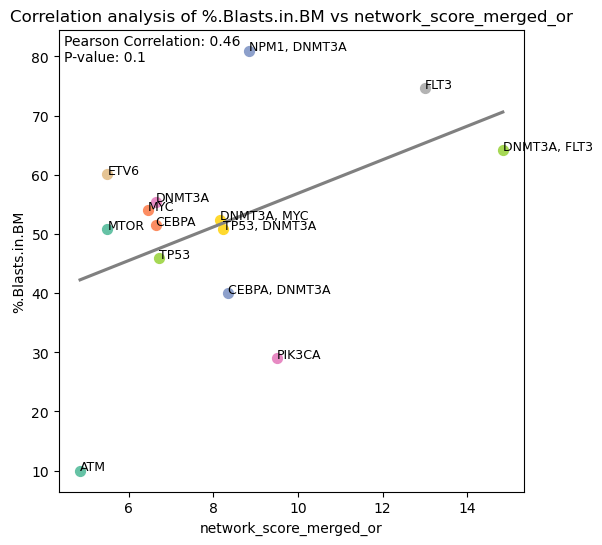

In [18]:
correlation_plot_avg( 'network_score_merged_and', '%.Blasts.in.BM')
correlation_plot_avg('network_score_merged_inhibitor_wins', '%.Blasts.in.BM')
correlation_plot_avg( 'network_score_merged_or', '%.Blasts.in.BM')

In [29]:
correlation_pc_avg('%.Blasts.in.BM')

Person Correlation of %.Blasts.in.BM vs network score


,pc,p_value
model1,0.245423,0.418977
model2,0.509576,0.075270
merged_and,0.347707,0.186955
merged_inhibitor_wins,0.322190,0.223603
merged_or,0.322190,0.223603


# Drug

In [ ]:
# Read data
file_path_drugs = './Data/BeatAML/drug_gene.csv'
df_drugs = pd.read_csv(file_path_drugs, usecols=['inhibitor', 'Symbol'])

# Count the number of unique patients with mutations in each gene
drug_model1 = df_drugs[df_drugs['Symbol'].isin(gene_model1)].copy()
drug_model2 = df_drugs[df_drugs['Symbol'].isin(gene_model2)].copy()

drug_model1['model1'] = 1
drug_model2['model2'] = 1
combined_df = pd.concat([drug_model1, drug_model2])

# Group by 'inhibitor' and 'Symbol', and aggregate by max to indicate presence
combined_df = combined_df.groupby(['inhibitor', 'Symbol'], as_index=False).max()

combined_df = combined_df.fillna(0)
combined_df[['model1', 'model2']] = combined_df[['model1', 'model2']].astype(int)
combined_df

In [ ]:
# Read data
file_path_drugs = './Data/BeatAML/beataml_probit_curve_fits_v4_dbgap.txt'
drugs = pd.read_csv(file_path_drugs, sep='\t')
print("# of samples per drug:")
drugs['inhibitor'].value_counts()

In [ ]:
inhibitor_counts = pd.DataFrame(drugs['inhibitor'].value_counts().sort_values(ascending=False))

grouped = inhibitor_counts.merge(combined_df, on = 'inhibitor', how = 'left')
grouped['color'] = 'gray'  # Default color

# Assign colors based on conditions
grouped.loc[(grouped['model1'] > 0) & (grouped['model2'] == 0), 'color'] = 'blue'
grouped.loc[(grouped['model1'] == 0) & (grouped['model2'] > 0), 'color'] = 'yellow'
grouped.loc[(grouped['model1'] > 0) & (grouped['model2'] > 0), 'color'] = 'green'

# Sort inhibitors by count
grouped_sorted = grouped.sort_values(by='count', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(grouped_sorted['inhibitor'], grouped_sorted['count'], color=grouped_sorted['color'])

# Improve layout for readability
plt.xticks(rotation=90, fontsize=5)
plt.xlabel('Inhibitor')
plt.ylabel('Count')
plt.title('# of samples per drug')
plt.tight_layout()

plt.show()

In [ ]:
# The model1 model
model1_drug_df = combined_df[combined_df['model1']==1]

# Generate unique mutation profiles and their perturbation strings
inhibitor_to_symbols = model1_drug_df.groupby('inhibitor')['Symbol'].apply(set).reset_index()

def generate_perturbation(mutations):
    perturbations = []
    for mutation in mutations:
        perturbations.append(f"{mutation}%0")
    return " ".join(perturbations)
    
inhibitor_to_symbols['perturbation_string'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
unique_perturbations = inhibitor_to_symbols['perturbation_string'].unique()

perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(model1, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

print(perturbation_to_scores)

In [ ]:
# Merge the df
merged_df = drugs.merge(inhibitor_to_symbols[['inhibitor', 'perturbation_string']], on='inhibitor', how='left')
merged_df['palma_network_score'] = merged_df['perturbation_string'].map(perturbation_to_scores)
drugs['palma_network_score'] = merged_df['palma_network_score']

# Update 'network_score' for blank
fps = biolqm.fixpoints(model1)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs.loc[drugs['palma_network_score'].isna() | (drugs['palma_network_score'] == ''), 'palma_network_score'] = network_score_wt

In [ ]:
# the merged model - AND
# Generate unique mutation profiles and their perturbation strings
inhibitor_to_symbols = combined_df.groupby('inhibitor')['Symbol'].apply(set).reset_index()

inhibitor_to_symbols['perturbation_string'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
unique_perturbations = inhibitor_to_symbols['perturbation_string'].unique()

perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

print(perturbation_to_scores)

# Merge the df
merged_df = drugs.merge(inhibitor_to_symbols[['inhibitor', 'perturbation_string']], on='inhibitor', how='left')
merged_df['network_score_merged_and'] = merged_df['perturbation_string'].map(perturbation_to_scores)
drugs['network_score_merged_and'] = merged_df['network_score_merged_and']

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs.loc[drugs['network_score_merged_and'].isna() | (drugs['network_score_merged_and'] == ''), 'network_score_merged_and'] = network_score_wt

In [ ]:
# the merged model - Inhibitor wins
perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

print(perturbation_to_scores)

# Merge the df
merged_df = drugs.merge(inhibitor_to_symbols[['inhibitor', 'perturbation_string']], on='inhibitor', how='left')
merged_df['network_score_merged_inhibitor_wins'] = merged_df['perturbation_string'].map(perturbation_to_scores)
drugs['network_score_merged_inhibitor_wins'] = merged_df['network_score_merged_inhibitor_wins']

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_inhibitor_wins)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs.loc[drugs['network_score_merged_inhibitor_wins'].isna() | (drugs['network_score_merged_inhibitor_wins'] == ''), 'network_score_merged_inhibitor_wins'] = network_score_wt

In [ ]:
# the merged model - OR
# Generate unique mutation profiles and their perturbation strings
perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

print(perturbation_to_scores)

# Merge the df
merged_df = drugs.merge(inhibitor_to_symbols[['inhibitor', 'perturbation_string']], on='inhibitor', how='left')
merged_df['network_score_merged_or'] = merged_df['perturbation_string'].map(perturbation_to_scores)
drugs['network_score_merged_or'] = merged_df['network_score_merged_or']

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_or)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs.loc[drugs['network_score_merged_or'].isna() | (drugs['network_score_merged_or'] == ''), 'network_score_merged_or'] = network_score_wt

In [ ]:
def correlation_plot_drug(pheno, drug_variable):
    df = drugs[drugs['inhibitor'].isin(combined_df['inhibitor'])].copy()

    # Convert clinical_variable to numeric, coercing errors to NaN
    df[drug_variable] = pd.to_numeric(df[drug_variable], errors='coerce')

    # Aggregate the data to calculate mean AUC for each drug
    mean_auc_per_drug = df.groupby('inhibitor')['auc'].mean().reset_index()
    
    # Merge the averaged AUC back into the original DataFrame
    aggregated_df = df.drop('auc', axis=1).drop_duplicates().merge(mean_auc_per_drug, on='inhibitor')

    # Drop rows where either drug_variable or pheno is NaN
    aggregated_df = aggregated_df.dropna(subset=[drug_variable, pheno])
    
    if len(aggregated_df) > 1:  # Ensure there are at least 2 data points
        pc, p_value = pearsonr(aggregated_df[drug_variable], aggregated_df[pheno])
    
        # Plotting
        plt.figure(figsize=(6, 6))
        
        # Plot the regression line
        sns.regplot(x=pheno, y=drug_variable, data=aggregated_df, ci=None, scatter=False, color='gray', label='Regression Line')
        
        # Plot points with colors based on 'inhibitors' 
        sns.scatterplot(data=aggregated_df, x=pheno, y=drug_variable, hue='inhibitor', palette='Set2', s=50, alpha=1, legend=False)
        
        # Handle annotations
        for inhibitor, group in aggregated_df.groupby('inhibitor'):
            # Select a representative point for annotation (e.g., mean values of the group)
            mean_pheno = group[pheno].mean()
            mean_drug_variable = group[drug_variable].mean()
            plt.annotate(inhibitor, (mean_pheno, mean_drug_variable), fontsize=9)
                
        plt.title('Correlation analysis of ' + drug_variable + ' vs ' + pheno)
        plt.xlabel(pheno)
        plt.ylabel(drug_variable)
        # Annotating the plot with Pearson Correlation and p-value
        plt.text(0.4, 0.95, f'Pearson Correlation: {pc:.2f}\nP-value: {p_value:.2g}', transform=plt.gca().transAxes, verticalalignment='top')
    
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")

correlation_plot_drug('palma_network_score', 'auc')

In [ ]:
correlation_plot_drug('network_score_merged_and', 'auc')

In [ ]:
correlation_plot_drug( 'network_score_merged_inhibitor_wins', 'auc')

In [ ]:
correlation_plot_drug( 'network_score_merged_or', 'auc')

## Using the ProxPath to define phenotype scores

In [ ]:
%run 'ProxPath.ipynb'

# the model1 results
pheno_model1 = proxpath(gene_model1)

# Calculate the phenotype score
perturbation_to_scores = {}
phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_model1_unique = pheno_model1.drop_duplicates(subset=['QueryNode', 'EndNode'])

# Generate unique mutation profiles and their perturbation strings
inhibitor_to_symbols = model1_drug_df.groupby('inhibitor')['Symbol'].apply(set).reset_index()
inhibitor_to_symbols['perturbation_string'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
unique_perturbations = inhibitor_to_symbols['perturbation_string'].unique()

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(model1, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']               
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Merge the df
merged_df['network_score_model1'] = merged_df['perturbation_string'].map(perturbation_to_scores)
drugs['network_score_model1'] = merged_df['network_score_model1']

# Update 'network_score' for blank
fps = biolqm.fixpoints(model1)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs.loc[drugs['network_score_model1'].isna() | (drugs['network_score_model1'] == ''), 'network_score_model1'] = results.loc['NETWORK'].item()


In [ ]:
# Calculate the phenotype score
pheno_merged = proxpath(gene_merged)
perturbation_to_scores = {}
phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_merged_unique = pheno_merged.drop_duplicates(subset=['QueryNode', 'EndNode'])

# Generate unique mutation profiles and their perturbation strings
inhibitor_to_symbols = combined_df.groupby('inhibitor')['Symbol'].apply(set).reset_index()

inhibitor_to_symbols['perturbation_string'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
unique_perturbations = inhibitor_to_symbols['perturbation_string'].unique()

#___________________ merged_and _________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Merge the df
merged_df['network_score_merged_and'] = merged_df['perturbation_string'].map(perturbation_to_scores)
drugs['network_score_merged_and'] = merged_df['network_score_merged_and']

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs.loc[drugs['network_score_merged_and'].isna() | (drugs['network_score_merged_and'] == ''), 'network_score_merged_and'] = results.loc['NETWORK'].item()

#___________________ merged_inhibitor_wins _________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Merge the df
merged_df['network_score_merged_inhibitor_wins'] = merged_df['perturbation_string'].map(perturbation_to_scores)
drugs['network_score_merged_inhibitor_wins'] = merged_df['network_score_merged_inhibitor_wins']

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_inhibitor_wins)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs.loc[drugs['network_score_merged_inhibitor_wins'].isna() | (drugs['network_score_merged_inhibitor_wins'] == ''), 'network_score_merged_inhibitor_wins'] = results.loc['NETWORK'].item()

#___________________ merged_or _________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Merge the df
merged_df['network_score_merged_or'] = merged_df['perturbation_string'].map(perturbation_to_scores)
drugs['network_score_merged_or'] = merged_df['network_score_merged_or']

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_or)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs.loc[drugs['network_score_merged_or'].isna() | (drugs['network_score_merged_or'] == ''), 'network_score_merged_or'] = results.loc['NETWORK'].item()


In [ ]:
correlation_plot_drug('network_score_model1', 'auc')
correlation_plot_drug('network_score_merged_and', 'auc')
correlation_plot_drug('network_score_merged_inhibitor_wins', 'auc')
correlation_plot_drug('network_score_merged_or', 'auc')

In [ ]:
def correlation_plot_drug_all(pheno, drug_variable):
    # Filter the drugs DataFrame to include only the relevant inhibitors
    df = drugs[drugs['inhibitor'].isin(combined_df['inhibitor'])].copy()

    # Convert drug_variable to numeric, coercing errors to NaN
    df[drug_variable] = pd.to_numeric(df[drug_variable], errors='coerce')

    # Drop rows where either drug_variable or pheno is NaN
    df = df.dropna(subset=[drug_variable, pheno])
    
    if len(df) > 1:  # Ensure there are at least 2 data points
        pc, p_value = pearsonr(df[pheno], df[drug_variable])
        
        # Plotting
        plt.figure(figsize=(6, 6))
        
        # Plot the regression line
        sns.regplot(x=pheno, y=drug_variable, data=df, ci=None, scatter=False, color='gray', label='Regression Line')
        
        # Plot points with colors based on 'inhibitor'
        palette = sns.color_palette('Set2', n_colors=df['inhibitor'].nunique())
        sns.scatterplot(data=df, x=pheno, y=drug_variable, hue='inhibitor', palette=palette, s=50, alpha=0.2, legend=False)
        
        # Handle annotations for one dot per inhibitor group
        annotated = set()
        for i, row in df.iterrows():
            if row['inhibitor'] not in annotated:
                plt.annotate(row['inhibitor'], (row[pheno], row[drug_variable]), fontsize=9)
                annotated.add(row['inhibitor'])
                
        plt.title(f'Correlation of {drug_variable} vs {pheno} across Inhibitors')
        plt.xlabel(pheno)
        plt.ylabel(drug_variable)
        # Annotating the plot with Pearson Correlation and p-value
        plt.text(0.4, 0.95, f'Pearson Correlation: {pc:.2f}\nP-value: {p_value:.2g}', ha='left', va='top', transform=plt.gca().transAxes)

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")

correlation_plot_drug_all('palma_network_score', 'auc')

In [ ]:
correlation_plot_drug_all('network_score_merged_and', 'auc')
correlation_plot_drug_all('network_score_merged_inhibitor_wins', 'auc')
correlation_plot_drug_all('network_score_merged_or', 'auc')

## Volcano plot

In [ ]:
def volcano_plot_drug(pheno, drug_variable):
    df = drugs.copy()
    # Calculate correlation, p-value, and prepare data for plotting
    results = []
    for sample_id in df['dbgap_subject_id'].unique():
        sample_df = df[df['dbgap_subject_id'] == sample_id]
        if len(sample_df) > 1:
            variable = sample_df[drug_variable]
            scores = sample_df[pheno]
            correlation, p_value = pearsonr(variable, scores)
            if not np.isnan(correlation):
                significance = abs(correlation) > 0.5 and p_value < 0.05
                color = 'purple' if significance else ('blue' if p_value < 0.05 else 'gray')
                results.append({
                    'dbgap_subject_id': sample_id,
                    'inhibitor': sample_df['inhibitor'].iloc[0],  # Assuming each sample ID has one associated inhibitor
                    'correlation': correlation,
                    'p_value': p_value,
                    'color': color,
                    'significant': significance
                })
    
    results_df = pd.DataFrame(results)
    results_df['-log10(p_value)'] = -np.log10(results_df['p_value'])
    
    # Volcano Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=results_df, x='correlation', y='-log10(p_value)', hue='color', palette={'gray':'gray', 'blue':'blue', 'purple':'purple'}, edgecolor='w', s=100, legend=False)
    for _, row in results_df.iterrows():
        if row['significant']:
            plt.text(row['correlation'], row['-log10(p_value)'], row['dbgap_subject_id'], horizontalalignment='left', size='small', color='black')
    plt.xlim(-1, 1)
    plt.ylim(0, 10)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('-log10(P-value)')
    plt.title(f'Volcano Plot of Correlation between {drug_variable} and {pheno}')
    plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')
    plt.tight_layout()
    
    # Plot Correlation Plots for Significant Samples
    significant_samples = results_df[results_df['significant']]
    n = len(significant_samples)
    
    if n > 0:
        fig, axs = plt.subplots(1, n, figsize=(5*n, 4), constrained_layout=True)
        if n == 1:
            axs = [axs]  # Make it iterable if there's only one subplot
        for ax, (_, row) in zip(axs, significant_samples.iterrows()):
            sample_id = row['dbgap_subject_id']
            sample_df = df[df['dbgap_subject_id'] == sample_id]
            sns.regplot(ax=ax, x=drug_variable, y=pheno, data=sample_df, color=row['color'])
            ax.set_title(f'Sample {sample_id}\nCorrelation: {row["correlation"]:.2f}, P-value: {row["p_value"]:.2g}')
            ax.set_xlabel(drug_variable)
            ax.set_ylabel(pheno)
    plt.show()

In [ ]:
volcano_plot_drug('palma_network_score', 'auc')

In [ ]:
volcano_plot_drug('network_score_merged_and', 'auc')
volcano_plot_drug('network_score_merged_inhibitor_wins', 'auc')
volcano_plot_drug('network_score_merged_or', 'auc')

In [ ]:
volcano_plot_drug('network_score_model1', 'auc')

In [ ]:
volcano_plot_drug('network_score_merged_and', 'auc')
volcano_plot_drug('network_score_merged_inhibitor_wins', 'auc')
volcano_plot_drug('network_score_merged_or', 'auc')

In [ ]:
volcano_plot_drug('palma_network_score', 'ic50')
volcano_plot_drug('network_score_merged_and', 'ic50')
volcano_plot_drug('network_score_merged_inhibitor_wins', 'ic50')
volcano_plot_drug('network_score_merged_or', 'ic50')

## Volcano plot per drug

In [ ]:
drugs_raw = pd.read_csv(file_path_drugs, sep='\t')
patient_to_pertb = mutations_df[['dbgap_subject_id','mutation_profile_model1', 'perturbation_string_model1','mutation_profile_merged', 'perturbation_string_merged']]
patient_to_pertb = patient_to_pertb.groupby('dbgap_subject_id').agg({
    'mutation_profile_merged': 'first', 
    'perturbation_string_merged': 'first',
    'mutation_profile_model1': 'first', 
    'perturbation_string_model1': 'first'
}).reset_index()

drugs_mut = drugs_raw.merge(patient_to_pertb, on='dbgap_subject_id', how='left')
drugs_mut = drugs_mut.merge(df_drugs[['inhibitor', 'Symbol']], on='inhibitor', how='left')

# Generate unique mutation profiles and their perturbation strings
drugs_mut_model1 = drugs_mut[drugs_mut['Symbol'].isin(gene_model1)]
inhibitor_to_symbols = drugs_mut_model1.groupby('inhibitor')['Symbol'].apply(set).reset_index()
def generate_perturbation(mutations):
    perturbations = []
    for mutation in mutations:
        perturbations.append(f"{mutation}%0")
    return " ".join(perturbations)
inhibitor_to_symbols['perturbation_drug'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
drugs_mut_model1 = drugs_mut_model1.merge(inhibitor_to_symbols[['inhibitor','perturbation_drug']], on='inhibitor', how='left')
drugs_mut_model1['pertubation_model1'] = drugs_mut_model1['perturbation_drug']+' '+drugs_mut_model1['perturbation_string_model1']

unique_perturbations = drugs_mut_model1['pertubation_model1'].unique()
perturbation_to_scores = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(model1, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

# Map the simulation results back to each patient
drugs_mut_model1['palma_network_score'] = drugs_mut_model1['pertubation_model1'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(model1)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs_mut_model1.loc[drugs_mut_model1['palma_network_score'].isna() | (drugs_mut_model1['palma_network_score'] == ''), 'palma_network_score'] = network_score_wt

In [ ]:
# Generate unique mutation profiles and their perturbation strings
drugs_mut_merged = drugs_mut[drugs_mut['Symbol'].isin(gene_merged)]
inhibitor_to_symbols = drugs_mut_merged.groupby('inhibitor')['Symbol'].apply(set).reset_index()
inhibitor_to_symbols['perturbation_drug'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
drugs_mut_merged = drugs_mut_merged.merge(inhibitor_to_symbols[['inhibitor','perturbation_drug']], on='inhibitor', how='left')
drugs_mut_merged['pertubation_merged'] = drugs_mut_merged['perturbation_drug']+' '+drugs_mut_merged['perturbation_string_merged']
unique_perturbations = drugs_mut_merged['pertubation_merged'].unique()

# _________________________the merged model - AND_________________________
perturbation_to_scores = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

# Merge the df
drugs_mut_merged['network_score_merged_and'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['network_score_merged_and'].isna() | (drugs_mut_merged['network_score_merged_and'] == ''), 'network_score_merged_and'] = network_score_wt

# _________________________the merged model - Inhibitor wins_________________________
perturbation_to_scores = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

# Merge the df
drugs_mut_merged['network_score_merged_inhibitor_wins'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['network_score_merged_inhibitor_wins'].isna() | (drugs_mut_merged['network_score_merged_inhibitor_wins'] == ''), 'network_score_merged_inhibitor_wins'] = network_score_wt

# _________________________the merged model - OR_________________________
perturbation_to_scores = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']


# Merge the df
drugs_mut_merged['network_score_merged_or'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['network_score_merged_or'].isna() | (drugs_mut_merged['network_score_merged_or'] == ''), 'network_score_merged_or'] = network_score_wt

## ProxPath

In [ ]:
%run 'ProxPath.ipynb'

# the model1 results
pheno_model1 = proxpath(gene_model1)

# Calculate the phenotype score
perturbation_to_scores = {}
phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_model1_unique = pheno_model1.drop_duplicates(subset=['QueryNode', 'EndNode'])

unique_perturbations = drugs_mut_model1['pertubation_model1'].unique()
perturbation_to_scores = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(model1, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']               
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Merge the df
drugs_mut_model1['network_score_model1'] = drugs_mut_model1['pertubation_model1'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(model1)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs_mut_model1.loc[drugs_mut_model1['network_score_model1'].isna() | (drugs_mut_model1['network_score_model1'] == ''), 'network_score_model1'] = results.loc['NETWORK'].item()

In [ ]:
# Calculate the phenotype score
pheno_merged = proxpath(gene_merged)
perturbation_to_scores = {}
phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_merged_unique = pheno_merged.drop_duplicates(subset=['QueryNode', 'EndNode'])

# Generate unique mutation profiles and their perturbation strings
unique_perturbations = drugs_mut_merged['pertubation_merged'].unique()

#___________________ merged_and _________________
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Merge the df
drugs_mut_merged['network_score_merged_and'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['network_score_merged_and'].isna() | (drugs_mut_merged['network_score_merged_and'] == ''), 'network_score_merged_and'] = results.loc['NETWORK'].item()

#___________________ merged_inhibitor_wins _________________
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Merge the df
drugs_mut_merged['network_score_merged_inhibitor_wins'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_inhibitor_wins)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['network_score_merged_inhibitor_wins'].isna() | (drugs_mut_merged['network_score_merged_inhibitor_wins'] == ''), 'network_score_merged_inhibitor_wins'] = results.loc['NETWORK'].item()

#___________________ merged_or _________________
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results.loc['NETWORK'].item()

# Merge the df
drugs_mut_merged['network_score_merged_or'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_or)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_model1_unique[pheno_model1_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['network_score_merged_or'].isna() | (drugs_mut_merged['network_score_merged_or'] == ''), 'network_score_merged_or'] = results.loc['NETWORK'].item()


In [ ]:
def volcano_plot_per_drug(pheno, drug_variable):
    if pheno.startswith('model1'):
        df = drugs_mut_model1.copy()
    else: df = drugs_mut_merged.copy()

    # Calculate correlation, p-value, and prepare data for plotting
    results = []
    for sample_drug in df['inhibitor'].unique():
        sample_df = df[df['inhibitor'] == sample_drug]
        if len(sample_df) > 1:
            variable = sample_df[drug_variable]
            scores = sample_df[pheno]
            correlation, p_value = pearsonr(variable, scores)
            if not np.isnan(correlation):
                significance = abs(correlation) > 0.5 and p_value < 0.05
                color = 'purple' if significance else ('blue' if p_value < 0.05 else 'gray')
                results.append({
                    'inhibitor': sample_drug,
                    'correlation': correlation,
                    'p_value': p_value,
                    'color': color,
                    'significant': significance
                })
    
    results_df = pd.DataFrame(results)
    results_df['-log10(p_value)'] = -np.log10(results_df['p_value'])
    
    # Volcano Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=results_df, x='correlation', y='-log10(p_value)', hue='color', palette={'gray':'gray', 'blue':'blue', 'purple':'purple'}, edgecolor='w', s=100, legend=False)
    for _, row in results_df.iterrows():
        if row['significant']:
            plt.text(row['correlation'], row['-log10(p_value)'], row['inhibitor'], horizontalalignment='left', size='small', color='black')
    plt.xlim(-1, 1)
    plt.ylim(0, 6)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('-log10(P-value)')
    plt.title(f'Volcano Plot of Correlation between {drug_variable} and {pheno}')
    plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')
    plt.tight_layout()
    
    # Plot Correlation Plots for Significant Samples
    significant_drugs = results_df[results_df['significant']]
    n = len(significant_drugs)
    
    if n > 0:
        fig, axs = plt.subplots(1, n, figsize=(5*n, 4), constrained_layout=True)
        if n == 1:
            axs = [axs]  # Make it iterable if there's only one subplot
        for ax, (_, row) in zip(axs, significant_drugs.iterrows()):
            sample_drug = row['inhibitor']
            sample_df = df[df['inhibitor'] == sample_drug]
            sns.regplot(ax=ax, x=drug_variable, y=pheno, data=sample_df, color=row['color'])
            ax.set_title(f'Sample {sample_id}\nCorrelation: {row["correlation"]:.2f}, P-value: {row["p_value"]:.2g}')
            ax.set_xlabel(drug_variable)
            ax.set_ylabel(pheno)
    plt.show()

In [ ]:
volcano_plot_per_drug('palma_network_score', 'auc')
volcano_plot_per_drug('network_score_merged_and', 'auc')
volcano_plot_per_drug('network_score_merged_inhibitor_wins', 'auc')
volcano_plot_per_drug('network_score_merged_or', 'auc')

In [ ]:
volcano_plot_per_drug('network_score_model1', 'auc')
volcano_plot_per_drug('network_score_merged_and', 'auc')
volcano_plot_per_drug('network_score_merged_inhibitor_wins', 'auc')
volcano_plot_per_drug('network_score_merged_or', 'auc')

## Mutation/drug association

> For each mutated gene in the exome sequencing samples, we determined all available (at least 5 patients) pairwise and three-way co-occurrence sets. For each drug and each valid set of genes (from one to three genes) we fit a linear model with AUC as the response and examined the linear contrast (i.e.. two-sided t-test) comparing the AUC of the gene(s) to the appropriate negative. For example the average AUC of the FLT3:DNMT3A:NPM1 mutants would be compared to average AUC of the samples negative for all three genes. FDR was computed using the BH over all the drugs.

In [ ]:
df = pd.merge(
    left=mutations,
    right=clinical,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample'
)
patient_to_mutations = df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()
patient_to_mutations['mutations'] = patient_to_mutations['symbol'].str.join(', ')

drugs = pd.merge(
    left=drugs,
    right=patient_to_mutations,
    on='dbgap_subject_id'
).drop('symbol', axis='columns')

drugs

In [ ]:
drugs = pd.read_csv('drugs.csv')

# Create a DataFrame to hold binary encodings for mutations
# Initialize with zeros
mutations_binary_df = pd.DataFrame(0, index=drugs.index, columns=mutations)

# Efficiently encode mutations into the DataFrame
for mutation in mutations:
    mutations_binary_df[mutation] = drugs['mutations'].apply(lambda x: int(mutation in str(x).split(',')))

# Concatenate the new DataFrame with the original 'drugs' DataFrame
drugs = pd.concat([drugs, mutations_binary_df], axis=1)

In [ ]:
# Initialize a list to store results
results = []

# Analyze each drug separately
for drug in drugs['inhibitor'].unique():
    df_drug = drugs[drugs['inhibitor'] == drug]
    
    # Analyze each mutation separately
    for mutation in mutations:
        # Subset for mutated and non-mutated groups
        mutated = df_drug[df_drug[mutation]]
        non_mutated = df_drug[~df_drug[mutation]]
        
        if len(mutated) < 5 or len(non_mutated) < 5:
            continue  # Skip if fewer than 5 samples in either group
        
        # Fit linear models: AUC ~ palma_network_score
        model_mutated = ols('auc ~ palma_network_score', data=mutated).fit()
        model_non_mutated = ols('auc ~ palma_network_score', data=non_mutated).fit()
        
        # Extract coefficients
        coef_mutated = model_mutated.params['palma_network_score']
        coef_non_mutated = model_non_mutated.params['palma_network_score']
        
        # Compare coefficients using t-test
        # Assume equal variance and calculate pooled standard deviation for simplicity
        std_pooled = np.sqrt(((len(mutated) - 1) * model_mutated.scale + (len(non_mutated) - 1) * model_non_mutated.scale) / (len(mutated) + len(non_mutated) - 2))
        se_diff = std_pooled * np.sqrt(1/len(mutated) + 1/len(non_mutated))
        t_stat = (coef_mutated - coef_non_mutated) / se_diff
        df = len(mutated) + len(non_mutated) - 2
        p_value = stats.t.sf(np.abs(t_stat), df) * 2  # two-sided p-value
        
        results.append({'drug': drug, 'mutation': mutation, 't_stat': t_stat, 'p_value': p_value})

# Convert results to DataFrame and adjust p-values for multiple comparisons
results_df = pd.DataFrame(results)
results_df['fdr_bh'] = multipletests(results_df['p_value'], method='fdr_bh')[1]

# Filter significant results based on FDR threshold
significant_results = results_df[results_df['fdr_bh'] < 0.05]

print(significant_results)